In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from mountaincar import MountainCar, MountainCarViewer

In [5]:
car = MountainCar()

### Parameters

In [50]:
ngrid_pos = 20
ngrid_speed = 20

In [51]:
int_pos = -150, 30
int_speed = -15, 15

In [69]:
parameter1 = 3.0
n_steps = 200
lmbda = 0.1
gamma = 0.95
eta = 0.9
dt = 0.01
n = 100
tau = 1
steps = 100
epsilon = 0.2

### Initialisation

In [53]:
center_dist_pos = (int_pos[1] - int_pos[0]) / ngrid_pos
center_dist_speed = (int_speed[1] - int_speed[0]) / ngrid_speed

In [54]:
x_pos = np.linspace(int_pos[0], int_pos[1], ngrid_pos)
y_speed = np.linspace(int_speed[0], int_speed[1], ngrid_speed)
y_speed_t = np.array([y_speed]).T # yy.T ?? try it

### Helper functions

In [55]:
def reward_activity(s, s_x, s_y):
    return np.exp(- ((x_pos - s[0]) / s_x) ** 2 - ((y_speed_t - s[1]) / s_y) ** 2)

In [63]:
def Q(s, a, w, s_x=center_dist_pos, s_y=center_dist_speed):
    return np.sum(w[:, :, a] * reward_activity(s, s_x, s_y))

In [10]:
def softmax(x, tau=1):
    e_x = np.exp(x / tau)
    return e_x / e_x.sum()

In [11]:
def toClosest(s):
    return np.abs(xx - s[0]).argmin(), np.abs(yy - s[1]).argmin()

## Sarsa Algorithm

<IPython.core.display.Javascript object>


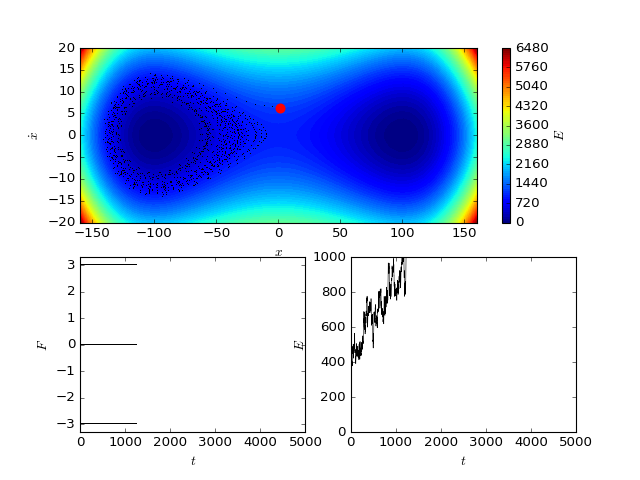

reward obtained at t =  1241.0


<IPython.core.display.Javascript object>


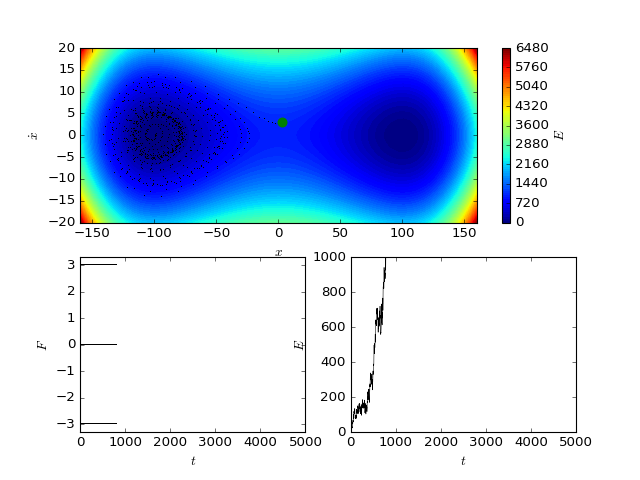

reward obtained at t =  796.0


<IPython.core.display.Javascript object>


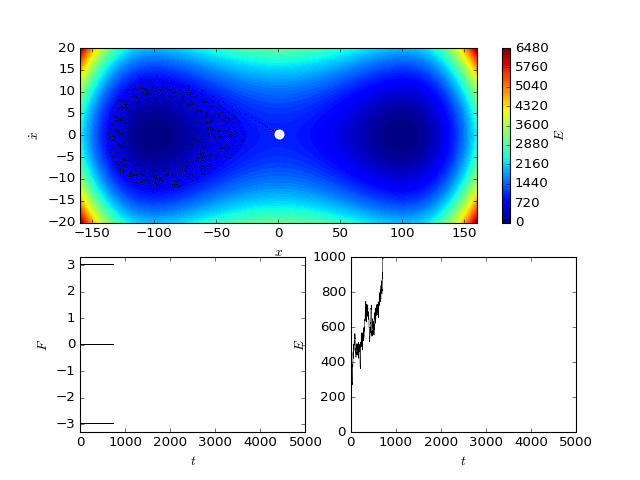

reward obtained at t =  740.0


<IPython.core.display.Javascript object>


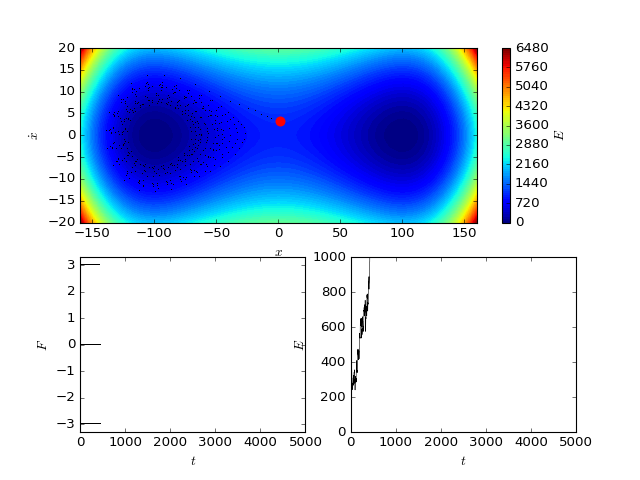

reward obtained at t =  436.0


<IPython.core.display.Javascript object>


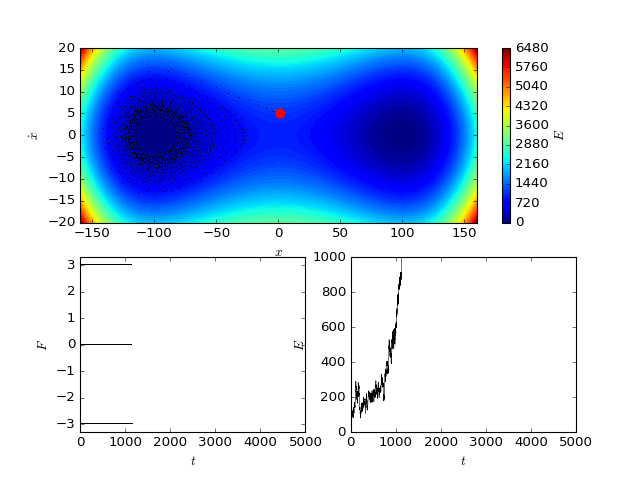

reward obtained at t =  1145.0


In [71]:

np.random.seed(1)
w = np.random.rand(width, height, 3)

for epi in np.arange(5):
    
    # no eligibility traces
    e = np.ones((width, height, 3))
    
    # initial state
    car.reset()
    mv = MountainCarViewer(car)
    mv.create_figure(5000, 5000)
    
    # initial state
    s0 = car.x, car.x_d
    # initial random action ???
    a0 = np.random.randint(3)
        
    for trial in np.arange(5000):        
        car.apply_force(a0 - 1)
        car.simulate_timesteps(steps, dt)
        
        s1 = car.x, car.x_d
        s1_d = toClosest(sp)

        if np.random.rand() < epsilon:
            a1 = np.argmax([Q(s1, a, w) for a in range(3)])
        else:
            a1 = np.random.randint(3)
        
        delta = car.R + gamma * Q(s1, a1, w) - Q(s0, a0, w)
        
        e *= gamma * lmbda
        e[spd[0], spd[1], a] += 1
        
        w += eta * delta * e
            
        a0 = a1
        s0 = s1
        
        mv.update_figure()
        plt.draw()
        
        if car.R > 0.0:
            print("\rreward obtained at t = ", car.t)
            break
        
